In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using CUDA, CUDA.CUBLAS, CUDA.CUSOLVER, CUDA.CUSPARSE
using BenchmarkTools

In [2]:
# Functions 
# System Equation Linear Sparse
function system_matrix_sparse(systemDimension::Integer, matrixA::AbstractMatrix)
    vectorDiagonalMain = 3 * ones(systemDimension)
    vectorDiagonalUpperLower = -1 * ones(systemDimension - 1)
    matrixA .= convert(Matrix, Tridiagonal(vectorDiagonalUpperLower, vectorDiagonalMain, vectorDiagonalUpperLower))
    for i = 1:systemDimension
        if matrixA[i, systemDimension-i+1] == 0.0
            matrixA[i, systemDimension-i+1] = 0.5
        end
    end
    return nothing
end
# 
function vector_independent_term(systemDimension::Integer, vectorB::AbstractVector)
    vectorB[1] = 2.5
    vectorB[systemDimension] = 2.5
    position::Integer = floor(systemDimension / 2)
    for i = 2:systemDimension-1
        if i == position || i == position + 1
            vectorB[i] = 1.0
        else
            vectorB[i] = 1.5
        end
    end
    return nothing
end

vector_independent_term (generic function with 1 method)

In [3]:
N = 2048
tA = Matrix{Float64}(undef, N, N)
b = Vector{Float64}(undef, N)
x_0 = zeros(N);
system_matrix_sparse(N, tA)
vector_independent_term(N, b);
A = sparse(tA)

2048×2048 SparseMatrixCSC{Float64, Int64} with 8188 stored entries:
⎡⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⎤
⎢⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⎥
⎢⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⎥
⎢⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⎥
⎣⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⎦

In [13]:
 function jacobi(A::AbstractMatrix, b::Vector{Float64})
        # Según el libro, viene siendo así el método matricial: x⁽ᵏ⁾= D⁻¹(L+U)x⁽ᵏ⁻¹⁾+D⁻¹b
        # Con D := La matriz diagonal A como matriz cuadrada,
        # -L y -U las matrices estríctamente Inferior (Lower) y Superior (Upper) de A, respectivamente
        # Definimos a N como la suma de estas dos últimas matrices.
        D = convert(Matrix, Diagonal(A))
        N = - triu(A,1) - tril(A,-1)
        x = zeros(length(b))
        normres = []
        for i = 1:40
            x = inv(D) * (N*x + b)
            normres = [normres;norm(A*x - b)]
        end
        return normres
    end


jacobi (generic function with 1 method)

In [14]:
function jacobi_sparse(A::SparseMatrixCSC{Float64, Int64}, b::Vector{Float64}, ϵ = 1e-5)
    D = Diagonal(A)
    N = - triu(A,1) - tril(A,-1)
    x = zeros(length(b))
    normres = []
    for i = 1:40
        x = D \ (N*x + b)
        normres = [normres;norm(A*x - b)]
    end
    return normres
end

jacobi_sparse (generic function with 2 methods)

In [15]:
function gauss_seidel(A::AbstractMatrix, b::Vector{Float64})
        # Según el libro, viene siendo así el método matricial: x⁽ᵏ⁾= (D-L)⁻¹(Ux⁽ᵏ⁻¹⁾+b)
        # Con D := La matriz diagonal A como matriz cuadrada,
        # -L y -U las matrices estríctamente Inferior (Lower) y Superior (Upper) de A, respectivamente
        U = - triu(A,1) 
        L₀ = tril(A,0)
        x = zeros(length(b))
        normres = []
        for i = 1:40 
            x = inv(L₀)*(U*x + b)
            normres = [normres;norm(A*x - b)]
        end
        return normres
    end

gauss_seidel (generic function with 1 method)

In [16]:
function gss_sparse(A::SparseMatrixCSC{Float64, Int64}, b::Vector{Float64}, ϵ = 1e-5)
    U = - triu(A,1) 
    L = tril(A,0)
    x = zeros(length(b))
    normres = []
    for i = 1:40 
        # x = inv(L₀)*(U*x + b)
        x = L \ (U*x + b)
        normres = [normres;norm(A*x - b)]
    end
    return normres
end

gss_sparse (generic function with 2 methods)

In [17]:
 function sor(A::AbstractMatrix, b::Vector{Float64}, ω = 1.2::Float64)
    
    D = Diagonal(A)
    U = - triu(A,1) 
    L = - tril(A,-1)
    x = zeros(length(b))

    DL = D-ω*L
    UD = ω*U+(1.0-ω)*D
    f = ω*b
    normres = []
    for i = 1:40
        # x = inv(L′) * (U′*x + b′)
        x = DL \ (UD * x + f)
        normres = [normres;norm(A*x - b)]
    end
    return normres
end

sor (generic function with 2 methods)

In [4]:
 function sor_sparse(A::SparseMatrixCSC{Float64, Int64}, b::Vector{Float64}, ω = 1.2::Float64, ϵ = 1e-5)
    
    D = Diagonal(A)
    U = - triu(A,1) 
    L = - tril(A,-1)
    x = zeros(length(b))

    DL = D-ω*L
    UD = ω*U+(1.0-ω)*D
    f = ω*b
    normres = []
    for i = 1:40
        # x = inv(L′) * (U′*x + b′)
        x = DL \ (UD * x + f)
        normres = [normres;norm(A*x - b)]
    end
    return normres
end

sor_sparse (generic function with 3 methods)

In [5]:
normres_sorsp = sor_sparse(A,b);

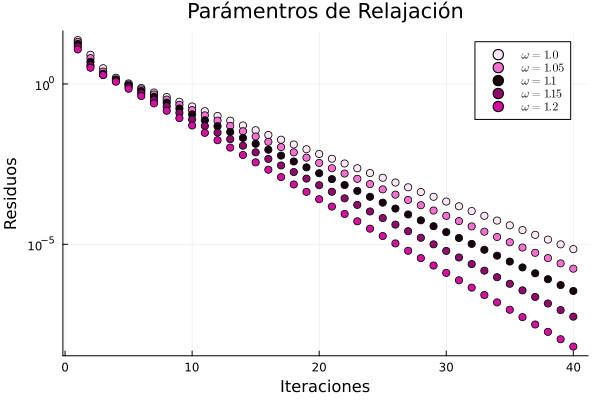

In [45]:
color = ["#fde7f7", "#f471d1", "#180212", "#8e0b6b", "#d510a1"]
ω_values = [1.0, 1.05, 1.1, 1.15, 1.2]
p = plot()
# ω = 1.0
for (i, ω) in enumerate(ω_values)
    normres_srss = [];
    normres_srss = sor_sparse(A,b,ω)
    p = Plots.scatter!(normres_srss, markersize=4, label = "\$\\omega=$ω\$", c=color[i])
    plot!(title="Parámentros de Relajación")
    p = plot!(xaxis=("Iteraciones") , yaxis = ("Residuos", :log))
    # ω = ω + 0.05
end
savefig(p, "ParametroOmegaSor")
display(p)

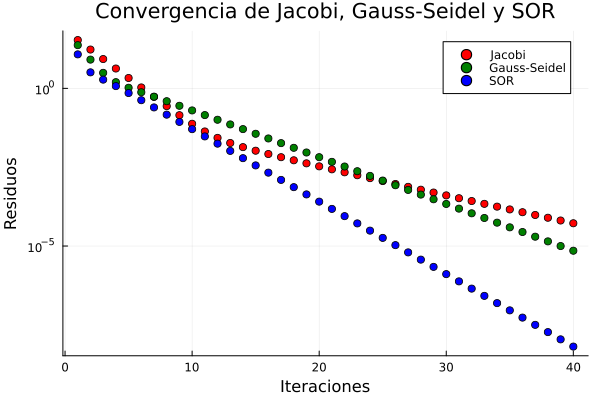

In [43]:
normres_jacobi = jacobi_sparse(A,b)
normres_gauss_seidel = gss_sparse(A,b)
normres_sor = sor_sparse(A,b)
p = Plots.scatter(normres_jacobi, markersize=4, label="Jacobi", c="red")
Plots.scatter!(normres_gauss_seidel, markersize=4, label="Gauss-Seidel",  c="green")
Plots.scatter!(normres_sor, markersize=4, label="SOR", c="blue")
# plot!(normres_jacobi, color="#6b0851", leg=false )
plot!(xaxis=("Iteraciones") , yaxis = ("Residuos", :log))
plot!(title="Convergencia de Jacobi, Gauss-Seidel y SOR")
savefig(p, "ConvergenciaMetodosClasicos")
display(p)

In [42]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
bJa = @benchmark jacobi(A,b)
bGSSS = @benchmark gauss_seidel(A, b)
bSOR = @benchmark sor(A, b);

In [43]:
display(bJa)
display(bGSSS)
display(bSOR)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):   78.770 ms … 442.687 ms  ┊ GC (min … max):  0.81% … 81.85%
 Time  (median):      79.966 ms               ┊ GC (median):     0.73%
 Time  (mean ± σ):   100.055 ms ±  80.881 ms  ┊ GC (mean ± σ):  20.17% ± 18.51%

  █                                                              
  █▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▁
  78.8 ms          Histogram: frequency by time          443 ms <

 Memory estimate: 90.82 MiB, allocs estimate: 373.

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  71.372 ms … 451.719 ms  ┊ GC (min … max):  0.75% … 79.82%
 Time  (median):     73.851 ms               ┊ GC (median):     0.78%
 Time  (mean ± σ):   97.596 ms ±  84.440 ms  ┊ GC (mean ± σ):  20.13% ± 18.01%

  █                                                             
  █▁▁▁▃▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▁
  71.4 ms         Histogram: frequency by time          452 ms <

 Memory estimate: 86.82 MiB, allocs estimate: 368.

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):   73.625 ms … 287.486 ms  ┊ GC (min … max):  1.28% … 74.82%
 Time  (median):      79.243 ms               ┊ GC (median):     0.75%
 Time  (mean ± σ):   108.958 ms ±  62.791 ms  ┊ GC (mean ± σ):  18.29% ± 21.22%

  █                                                              
  █▇▄▄▁▁▁▁▇▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▄ ▁
  73.6 ms          Histogram: frequency by time          287 ms <

 Memory estimate: 100.83 MiB, allocs estimate: 384.

In [143]:
function conjugate_gradient_method(
    matrixA::AbstractMatrix,
    vectorB::AbstractVector,
    vectorX_initial::AbstractVector,
    maximumIteration::Integer)

    vectorX_current = vectorX_initial
    vectorR_current = vectorB - matrixA * vectorX_current
    vectorD_current = vectorR_current
    normres_cgm = []

    for k = 1:maximumIteration
        vectorAD = matrixA * vectorD_current
        alpha = dot(vectorR_current, vectorR_current) / dot(vectorAD, vectorD_current)
        vectorX_next = vectorX_current + alpha * vectorD_current
        # normres_cgm = [normres_cgm;norm(b-A*vectorX_next)]
        # Stop Condition
        # methodError = norm(vectorX_next - vectorX_exactSolution) / norm(vectorX_next)
        # if methodError <= tolerance
        #     iterationNumber = k
        #     break
        # end
        vectorR_next = vectorR_current - alpha * vectorAD
        normres_cgm = [normres_cgm;norm(vectorR_next)]
        beta = dot(vectorR_next, vectorR_next) / dot(vectorR_current, vectorR_current)
        vectorD_next = vectorR_next + beta * vectorD_current
        # Update
        vectorX_current = vectorX_next
        vectorR_current = vectorR_next
        vectorD_current = vectorD_next
    end

    return normres_cgm
end

conjugate_gradient_method (generic function with 3 methods)

In [4]:
function cgm_sparse(
    A::SparseMatrixCSC{Float64,Int64},
    b::AbstractVector,
    ϵ=1e-5)

    x_c = zeros(length(b))
    r_c = b - A * x_c
    d_c = r_c
    normres_cgm = []

    for k = 1:40
        vectorAD = A * d_c
        alpha = dot(r_c, r_c) / dot(vectorAD, d_c)
        x_n = x_c + alpha * d_c
        # normres_cgm = [normres_cgm;norm(b-A*x_n)]
        # Stop Condition
        # methodError = norm(x_n - vectorX_exactSolution) / norm(x_n)
        # if methodError <= tolerance
        #     iterationNumber = k
        #     break
        # end
        r_n = r_c - alpha * vectorAD
        normres_cgm = [normres_cgm;norm(r_n)]
        beta = dot(r_n, r_n) / dot(r_c, r_c)
        d_n = r_n + beta * d_c
        # Update
        x_c = x_n
        r_c = r_n
        d_c = d_n
    end

    return normres_cgm
end

cgm_sparse (generic function with 2 methods)

In [5]:
normres_cgm = cgm_sparse(A,b);

In [6]:
function cgm_precondicionado_sparse(
    A::SparseMatrixCSC{Float64,Int64},
    b::AbstractVector,
    precondicionador::String,
    ϵ=1e-5)

    D = Diagonal(A)
    U = triu(A, 1)
    L = tril(A, -1)
    α = 1.2

    if precondicionador == "Jacobi"
        Ms = [D]
    end
    if precondicionador == "SOR"
        M_sor_1 = I + (α * L * inv(D))
        M_sor_2 = D + α * U
        Ms = [M_sor_1, M_sor_2]
    end

    x_c = zeros(length(b))
    r_c = b - A * x_c
    z = r_c
    [z = M \ z for M ∈ Ms]
    d_c = z
    normres_cgm = []

    for k = 1:40
        Ad = A * d_c
        alpha = dot(r_c, z) / dot(Ad, d_c)
        x_n = x_c + alpha * d_c
        r_n = r_c - alpha * Ad
        normres_cgm = [normres_cgm; norm(r_n)]
        z_next = r_n
        [z_next = M \ z_next for M ∈ Ms]
        beta = dot(r_n, z) / dot(r_c, z)
        d_n = z_next + beta * d_c
        # Update
        x_c = x_n
        r_c = r_n
        d_c = d_n
        z = z_next
    end

    return normres_cgm
end

cgm_precondicionado_sparse (generic function with 2 methods)

In [7]:
normres_cgm = cgm_precondicionado_sparse(A,b,"SOR");

In [8]:

function conjugate_gradient_method_precondicionado(
    matrixA::AbstractMatrix,
    vectorB::AbstractVector,
    ϵ=1e-5)

    # M = Diagonal(matrixA)
    D = Diagonal(A)
    U = triu(A,1) 
    L = tril(A,-1)
    M_gauss_seidel_1 = I+(L*inv(D))
    M_gauss_seidel_2 = D+U
    α = 1.13
    M_sor_1 = I+(α*L*inv(D))
    M_sor_2 = D+α*U
    # Ms = [M_gauss_seidel_1, M_gauss_seidel_2]
    Ms = [M_sor_1, M_sor_2]

    vectorX_current = zeros(length(vectorB))
    vectorR_current = vectorB - matrixA * vectorX_current
    # z = M \ vectorR_current
    z = vectorR_current
    [z = M \ z for M ∈ Ms]
    vectorD_current = z
    normres_cgm = []

    for k = 1:40
        vectorAD = matrixA * vectorD_current
        alpha = dot(vectorR_current, z) / dot(vectorAD, vectorD_current)
        vectorX_next = vectorX_current + alpha * vectorD_current
        # normres_cgm = [normres_cgm;norm(b-A*vectorX_next)]
        # Stop Conditioj
        # methodError = norm(vectorX_next - vectorX_exactSolution) / norm(vectorX_next)
        # if methodError <= tolerance
        #     iterationNumber = k
        #     break
        # end
        vectorR_next = vectorR_current - alpha * vectorAD
        normres_cgm = [normres_cgm;norm(vectorR_next)]
        # z_next = M \ vectorR_next
        z_next = vectorR_next
        [z_next = M \ z_next for M ∈ Ms]
        beta = dot(vectorR_next, z) / dot(vectorR_current, z)
        vectorD_next = z_next + beta * vectorD_current
        # Update
        vectorX_current = vectorX_next
        vectorR_current = vectorR_next
        vectorD_current = vectorD_next
        z = z_next
    end

    return normres_cgm
end

conjugate_gradient_method_precondicionado (generic function with 2 methods)

In [30]:
normres_cgm = cgm_sparse(A,b);
normres_cgm_pJ = cgm_precondicionado_sparse(A,b,"Jacobi");
normres_cgm_pS = cgm_precondicionado_sparse(A,b,"SOR");

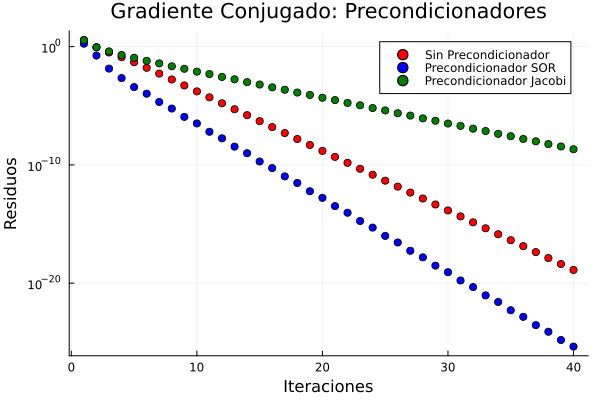

In [44]:
f2 = Plots.scatter(normres_cgm, markersize=4, label="Sin Precondicionador", c="red")
Plots.scatter!(normres_cgm_pS, markersize=4, label="Precondicionador SOR", c="blue")
Plots.scatter!(normres_cgm_pJ, markersize=4, label="Precondicionador Jacobi", c="green")
plot!(xaxis=("Iteraciones") , yaxis = ("Residuos", :log))
plot!(title="Gradiente Conjugado: Precondicionadores")
savefig(f2, "convergenciaGCconPrecondicionadores")
display(f2)

In [146]:
bcg = @benchmark conjugate_gradient_method(A,b,x_0,40);
# bcgp = @benchmark conjugate_gradient_method_precondicionado(A,b);

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  1.522 ms …   2.389 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.540 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.623 ms ± 205.003 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                            
  █▃▁▃▅▃▃▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▁
  1.52 ms         Histogram: frequency by time        2.39 ms <

 Memory estimate: 1.14 MiB, allocs estimate: 363.

In [280]:
display(bcg)
# display(bcgp)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  45.358 ms … 79.081 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     57.513 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   56.959 ms ±  9.224 ms  ┊ GC (mean ± σ):  0.15% ± 0.47%

  █ ▁█▁   ▁    ▁ ▁    ▁ █▁   ▁    ▁ ▁▁ ▁▁                   ▁  
  █▁███▁▁▁█▁▁▁▁█▁█▁▁▁▁█▁██▁▁▁█▁▁▁▁█▁██▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  45.4 ms         Histogram: frequency by time        79.1 ms <

 Memory estimate: 4.45 MiB, allocs estimate: 363.

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  420.633 ms … 745.592 ms  ┊ GC (min … max):  2.21% … 35.06%
 Time  (median):     481.343 ms               ┊ GC (median):     5.65%
 Time  (mean ± σ):   518.764 ms ± 105.530 ms  ┊ GC (mean ± σ):  12.61% ± 11.89%

  ██  █  █  █ █  █                   █ █                      █  
  ██▁▁█▁▁█▁▁█▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  421 ms           Histogram: frequency by time          746 ms <

 Memory estimate: 325.82 MiB, allocs estimate: 999.

In [9]:

   function leastsquares(H, r)
        r′ = zeros(size(H)[1])
        r′[1] = norm(r)
        x = H \ r′
    end

  function gmres(A::SparseMatrixCSC{Float64, Int64}, b::Vector{Float64}, ϵ = 1e-5)
        x₀ = zeros(length(b))
        residual₀ = b - A*x₀
        q = [residual₀ / norm(residual₀)]
        normres = []

        k = 1
        x = x₀
        H = zeros(2,1)
        residual = residual₀
        counter = 0
        while norm(residual) > ϵ
            y = A*q[k]
            for j ∈ 1:k
                H[j,k] = q[j]' * y
                y -= H[j,k]*q[j]
            end
            H[k+1,k] = norm(y)
            push!(q, y/H[k+1,k])
            H = vcat(H, zeros(1, size(H)[2]))
            H = hcat(H, zeros(size(H)[1], 1))
            if k % 10 == 0
                display(k)
                c = leastsquares(H, residual₀)
                Q = hcat(q...)
                x = Q*c + x₀
                residual = A*x - b
            end
            normres = [normres;norm(A*x-b)]
            k += 1
            counter+=1
        end
        return normres
    end

gmres (generic function with 2 methods)

In [10]:
normres_gmres = gmres(A,b)

10

20

20-element Vector{Any}:
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
  0.00015587676559127155
  0.00015587676559127155
  0.00015587676559127155
  0.00015587676559127155
  0.00015587676559127155
  0.00015587676559127155
  0.00015587676559127155
  0.00015587676559127155
  0.00015587676559127155
  0.00015587676559127155
  1.4467551010650316e-9

In [11]:
   function leastsquares(H, r)
        r′ = zeros(size(H)[1])
        r′[1] = norm(r)
        x = H \ r′
    end
    
    function gmresreiniciado(A::SparseMatrixCSC{Float64, Int64}, b::Vector{Float64}, ϵ = 1e-5)
        x₀ = zeros(length(b))
        residual₀ = b - A*x₀
        q = [residual₀ / norm(residual₀)]
        norm_gmres = []

        k = 1
        x = x₀
        H = zeros(2,1)
        residual = residual₀
        counter = 0
        modulo = 15 # obtenermodulo(cbrt(length(b)))
        while norm(residual) > ϵ
            y = A*q[k]
            for j ∈ 1:k
                H[j,k] = q[j]' * y
                y -= H[j,k]*q[j]
            end
            H[k+1,k] = norm(y)
            push!(q, y/H[k+1,k])
            H = vcat(H, zeros(1, size(H)[2]))
            H = hcat(H, zeros(size(H)[1], 1))
            k += 1
            if k % modulo == 0 
                c = leastsquares(H, residual₀)
                Q = hcat(q...)
                x = Q*c + x₀
                residual = A*x - b
                x₀, residual₀, q, k, H = reiniciarvariables(x, A, b)
            end
            norm_gmres = [norm_gmres;norm(residual₀)]
            counter+=1
        end
        return norm_gmres
    end


    function reiniciarvariables(x, A, b)
        k = 1
        x₀ = x
        r = b - A*x₀
        H = zeros(2,1)
        q = [r / norm(r)]
        return x₀, r, q, k, H
    end


    function obtenermodulo(dims)
        if dims == 10
            modulo = 15
        elseif dims == 20
            modulo = 20
        elseif dims == 30
            modulo = 35
        elseif dims == 40
            modulo = 25
        elseif dims == 50
            modulo = 15
        elseif dims == 60
            modulo = 15
        elseif dims == 80
            modulo = 30
        elseif dims == 100
            modulo = 35
        end
        return modulo
    end

obtenermodulo (generic function with 1 method)

In [12]:
gmresreiniciado(A,b)

14-element Vector{Any}:
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
 67.9227502387823
  1.5135321894701598e-6

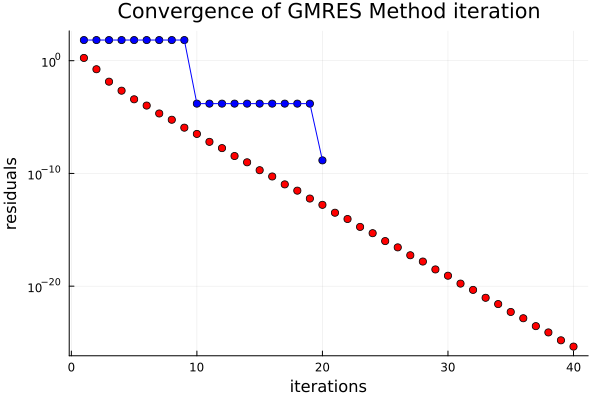

In [15]:
Plots.scatter(normres_cgm, markersize=4, c="red", leg=false)
Plots.scatter!(normres_gmres, markersize=4, c="blue", leg=false)
plot!(normres_gmres, color="blue", leg=false )
plot!(xaxis=("iterations") , yaxis = ("residuals", :log))
plot!(title="Convergence of GMRES Method iteration")

In [16]:
function precondition(name, A, b)
        if name == "Jacobi"
            M_jacobi = Diagonal(A)
            return [M_jacobi]

        elseif name == "Gauss-Seidel"
            D = Diagonal(A)
            U = triu(A,1) 
            L = tril(A,-1)
            M_gauss_seidel_1 = I+(L*inv(D))
            M_gauss_seidel_2 = D+U
            return [M_gauss_seidel_1, M_gauss_seidel_2]

        elseif name == "SOR"
            α = 1.13
            D = Diagonal(A)
            U = triu(A,1) 
            L = tril(A,-1)
            M_sor_1 = I+(α*L*inv(D))
            M_sor_2 = D+α*U
            return [M_sor_1, M_sor_2]
        end
    end

    function gmresprecondicionadoreiniciado(A::AbstractMatrix, b::Vector{Float64}, precondition_name::String)
        ϵ = 1e-5
        x₀ = zeros(length(b))
        Ms = precondition(precondition_name, A, b)
        residual₀ = b - A*x₀
        [residual₀ = M\residual₀ for M ∈ Ms]
        q = [residual₀ / norm(residual₀)]
        norm_gmresp = []

        k = 1
        x = x₀
        H = zeros(2,1)
        residual = residual₀
        counter = 0
        # modulo = obtenermoduloprecondicionado(precondition_name, cbrt(length(b)))
        while norm(residual) > ϵ
            ω = A*q[k]
            [ω = M\ω for M ∈ Ms]
            for j ∈ 1:k
                H[j,k] = q[j]' * ω
                ω -= H[j,k]*q[j]
            end
            H[k+1,k] = norm(ω)
            push!(q, ω/H[k+1,k])
            H = vcat(H, zeros(1, size(H)[2]))
            H = hcat(H, zeros(size(H)[1], 1))
            k += 1
            if k % 5 == 0
                c = leastsquares(H, residual₀)
                Q = hcat(q...)
                x = Q*c + x₀
                residual = A*x - b
                [residual = M\residual for M ∈ Ms]
                x₀, residual₀, q, k, H = reiniciarvariablesprecondicionado(x, A, b, Ms)
            end
            norm_gmresp = [norm_gmresp;norm(residual₀)]
            counter+=1
        end
        return norm_gmresp
    end

    function reiniciarvariablesprecondicionado(x::Vector, A::AbstractMatrix, b::Vector{Float64}, Ms::Vector)
        k = 1
        x₀ = x
        H = zeros(2,1) 
        residual₀ = b - A*x₀
        [residual₀ = M\residual₀ for M ∈ Ms]
        q = [residual₀ / norm(residual₀)]
        return x₀, residual₀, q, k, H
    end

    # function reiniciarvariablesprecondicionado(x, A, b, Ms::Vector)
    #     k = 1
    #     x₀ = x
    #     H = zeros(2,1)

    #     residual₀ = b - A*x₀
    #     [residual₀ = M\residual₀ for M ∈ Ms]
    #     q = [residual₀ / norm(residual₀)]
    #     return x₀, residual₀, q, k, H
    # end

reiniciarvariablesprecondicionado (generic function with 1 method)

In [17]:
gmresprecondicionadoreiniciado(A,b,x_0,"Jacobi")

MethodError: MethodError: no method matching gmresprecondicionadoreiniciado(::SparseMatrixCSC{Float64, Int64}, ::Vector{Float64}, ::Vector{Float64}, ::String)

Closest candidates are:
  gmresprecondicionadoreiniciado(::AbstractMatrix, ::Vector{Float64}, !Matched::String)
   @ Main ~/Documents/WorkSpaces/pesadilla/solver.ipynb:25


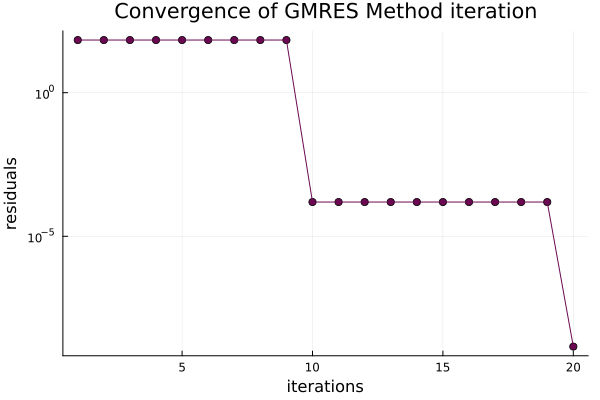

In [18]:
scatter(normres_gmres, markersize=4, c="#6b0851", leg=false)
plot!(normres_gmres, color="#6b0851", leg=false )
plot!(xaxis=("iterations") , yaxis = ("residuals", :log))
plot!(title="Convergence of GMRES Method iteration")

In [19]:
N = 128
A = Matrix{Float64}(undef, N, N)
b = Vector{Float64}(undef, N)
x_0 = zeros(N);
system_matrix_sparse(N, A)
vector_independent_term(N, b);

In [148]:
# dA = CuArray(A)
# dA = sparse(dA)
# db = CuArray(b)
A = sparse(A)
spA = CuSparseMatrixCSC(A)
typeof(spA)
# for i = 1:2
#     dA*db + db
# end

CuSparseMatrixCSC{Float64, Int32}

In [149]:
function paralleljacobi(A, b, ϵ = 1e-5)
    
    D = convert(Matrix, Diagonal(A))
    d_D = CuArray{Float64}(D)
    N = -triu(A, 1) - tril(A, -1)
    d_N = CuArray{Float64}(N)

    d_A = CuArray{Float64}(A)
    d_B = CuArray{Float64}(b)
    d_X = CUDA.zeros(size(b))
    # counter = 0
    # while CUBLAS.norm(d_A*d_X - d_B) > ϵ
    #     d_X = d_D \ (d_N*d_X + d_B)
    #     counter+=1
    # end
    normres = []
    for i = 1:40
        d_X = d_D \ (d_N * d_X + d_B)
        normres = [normres; CUBLAS.norm(d_A * d_X - d_B)]
    end
    return normres
end

paralleljacobi (generic function with 2 methods)

In [145]:
 function paralleljacobisparse(A, b,ϵ = 1e-5)
    d = diag(A)
    d_d = CuArray{Float64}(d)
    N = - triu(A,1) - tril(A,-1)
    d_N = CuSparseMatrixCSR{Float64}(N)

    d_A = CuSparseMatrixCSR{Float64}(A)
    d_b = CuArray{Float64}(b)
    d_x = CUDA.zeros(Float64, size(b))
    # counter = 0
    # while norm(d_A*d_x - d_b) > ϵ
    #     d_x = (d_N*d_x + d_b) ./ d_d
    #     counter+=1
    # end
    # display(d_x)
    normres = []
    for i = 1:40
        d_x = (d_N*d_x + d_b) ./ d_d
        normres = [normres;CUBLAS.norm(d_A*d_x - d_b)]
    end
    return normres
end

paralleljacobisparse (generic function with 2 methods)

In [150]:
# normres_jacobi = paralleljacobi(A,b)
normres_jacobi = paralleljacobisparse(A,b)

40-element Vector{Any}:
 8.48118833392795
 4.250408477102198
 2.143101011255523
 1.0885498537430343
 0.5593964553809485
 0.2934494993836192
 0.15968536858705937
 0.09223819215117135
 0.05773205857417727
 0.03925363358338614
 ⋮
 0.00026700950348673263
 0.00021752187933252667
 0.000177324163019467
 0.00014464558198244395
 0.00011805914075463617
 9.641339634712896e-5
 7.877813347693226e-5
 6.440101835974818e-5
 5.267294636764913e-5

In [111]:
function parallelgaussseidel(A, b, ϵ = 1e-5)
    U = - triu(A,1)
    L = tril(A,0)
    d_U = CuSparseMatrixCSC{Float64}(U)

    d_A = CuSparseMatrixCSC{Float64}(A)
    d_b = CuArray{Float64}(b)
    d_x = CUDA.zeros(Float64, size(b))

    # counter = 0
    # while CUBLAS.norm(d_A*d_x - d_b) > ϵ
    #     d_F = d_U*d_x + d_b
    #     d_x = d_L \ d_F
    #     counter+=1
    # end
    # return counter

    normres = []
    for i = 1:40
        f = Array(d_U*d_x + d_b)
        d_x = CuArray{Float64}(L\f)
        normres = [normres;CUBLAS.norm(d_A*d_x - d_b)]
    end
    return normres
end

parallelgaussseidel (generic function with 2 methods)

In [144]:

normres_gauss_seidel = parallelgaussseidel(A,b);

MethodError: MethodError: no method matching (CuSparseMatrixCSC{Float64})(::Matrix{Float64})

Closest candidates are:
  (CuSparseMatrixCSC{T})(!Matched::Adjoint{T, <:CuSparseMatrixCSR{T}}) where T<:Real
   @ CUDA ~/.julia/packages/CUDA/htRwP/lib/cusparse/conversions.jl:298
  (CuSparseMatrixCSC{T})(!Matched::SparseMatrixCSC) where T
   @ CUDA ~/.julia/packages/CUDA/htRwP/lib/cusparse/array.jl:422
  (CuSparseMatrixCSC{T})(!Matched::SparseVector) where T
   @ CUDA ~/.julia/packages/CUDA/htRwP/lib/cusparse/array.jl:419
  ...


In [118]:
 function parallelsor(A, b, ω = 1.2, ϵ = 1e-5)
    D = Diagonal(A)
    U = - triu(A,1)
    L = - tril(A,-1)

    # L′ = D-ω*L
    # U′ = ω*U+(1.0-ω)*D
    # b′ = ω*b
    DL = D-ω*L
    UD = ω*U+(1.0-ω)*D
    f = ω*b

    d_UD = CuSparseMatrixCSC{Float64}(UD)
    d_f = CuArray{Float64}(f)

    d_A = CuSparseMatrixCSC{Float64}(A)
    d_b = CuArray{Float64}(b)
    d_x = CUDA.zeros(Float64, size(b))

    # counter = 0
    # while CUBLAS.norm(d_A*d_x - d_B) > ϵ
    #     d_G = d_UD*d_x + d_f
    #     d_x = d_DL \ d_G
    #     counter+=1
    # end
    # return counter
    normres = []
    for i = 1:40
        g = Array(d_UD*d_x + d_f)
        d_x = CuArray{Float64}(DL \ g)
        normres = [normres;CUBLAS.norm(d_A*d_x - d_b)]
    end
    return normres
end

parallelsor (generic function with 3 methods)

In [119]:
norm_sor = parallelsor(A,b)

40-element Vector{Any}:
 3.082655009040409
 0.8904827725855416
 0.4921467295436302
 0.29313083799117823
 0.1723299477794778
 0.10045946621840675
 0.05865919757922749
 0.03424137784299931
 0.020024853615484204
 0.011713539405037613
 ⋮
 9.294451825311625e-8
 5.454184226187282e-8
 3.2007377467534434e-8
 1.8783813373014597e-8
 1.1023765660493673e-8
 6.469757524229044e-9
 3.797144873076289e-9
 2.2286241440225214e-9
 1.3080556890206479e-9

In [12]:
# tr = paralleljacobi(A,b)
# tr = parallelgaussseidel(A,b)
# tr = parallelsor(A,b)
# d_A = CuArray{Float64}(A)
# d_B = CuArray{Float64}(b)
# d_X = CuArray{Float64}(zeros(size(b)))
# CUBLAS.norm(d_B - d_A*d_X)

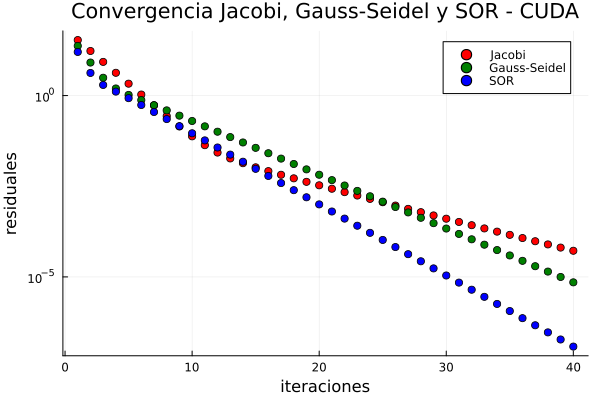

In [17]:
normres_jacobi = paralleljacobi(A,b)
normres_gauss_seidel = parallelgaussseidel(A,b)
normres_sor = parallelsor(A,b)
p = scatter(normres_jacobi, markersize=4, label="Jacobi", c="red")
Plots.scatter!(normres_gauss_seidel, markersize=4, label="Gauss-Seidel",  c="green")
Plots.scatter!(normres_sor, markersize=4, label="SOR", c="blue")
plot!(xaxis=("iteraciones") , yaxis = ("residuales", :log))
plot!(title="Convergencia Jacobi, Gauss-Seidel y SOR - CUDA")
# savefig(p, "ConvergenciaCuda")

In [120]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
# bJap = @benchmark paralleljacobisparse(A,b);
# bJapp = @benchmark paralleljacobi(A,b);
# bGSSSp = @benchmark parallelgaussseidel(A, b)
bSORp = @benchmark parallelsor(A, b);

In [121]:
# display(bJap)
# display(bJapp)
# display(bGSSSp)
display(bSORp)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  6.258 ms …   9.188 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.555 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.841 ms ± 854.001 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █                                                           
  ██▁█▁▅▅▁█▅▅▁▅▁▁▁▁▅▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  6.26 ms         Histogram: frequency by time        9.19 ms <

 Memory estimate: 326.20 KiB, allocs estimate: 6444.

In [140]:
function parallel_cgm(A, b, tolerance = 1e-5)

    d_A = CuSparseMatrixCSC{Float64}(A)
    d_B = CuArray(b)

    x_c = zeros(Float64,size(b))
    d_X_c = CuArray(x_c)
    # r_c = b - A * x_c
    r_c = Array(d_B - d_A * d_X_c)
    d_c = r_c
    d_D_c = CuArray(d_c)
    normres_cgm = []

    for k = 1:40
        Ad_c = Array(d_A * d_D_c)
        alpha = dot(r_c, r_c) / dot(Ad_c, d_c)
        x_n = x_c + alpha * d_c
        # normres_cgm = [normres_cgm;norm(b-A*x_n)]
        # Stop Condition
        # methodError = norm(x_n - vectorX_exactSolution) / norm(x_n)
        # if methodError <= tolerance
        #     iterationNumber = k
        #     break
        # end
        r_n = r_c - alpha * Ad_c
        normres_cgm = [normres_cgm;norm(r_n)]
        beta = dot(r_n, r_n) / dot(r_c, r_c)
        d_n = r_n + beta * d_c
        # Update
        x_c = x_n
        r_c = r_n
        d_c = d_n
        d_D_c = CuArray(d_c)
    end

    return normres_cgm
end

parallel_cgm (generic function with 2 methods)

In [124]:
normres_cgmsp = parallel_cgm(A,b)

40-element Vector{Any}:
 3.4391672837784144
 0.8739129136874152
 0.318496793616174
 0.12679207513213483
 0.046813918437243814
 0.015795767085149133
 0.005086402638470374
 0.0016088915717946228
 0.0005058104854908546
 0.0001586925171432587
 ⋮
 1.252809313633269e-15
 2.322681331725527e-16
 5.786132052668716e-17
 1.7196636945480472e-17
 5.341123484879815e-18
 1.6734804146218925e-18
 5.2513318024769555e-19
 1.648763135175841e-19
 5.188087067861935e-20

In [134]:
function parallel_cgm_precondicionado(A::AbstractMatrix, b::AbstractVector, tolerance = 1e-5)

    d_A = CuSparseMatrixCSC(A)
    d_b = CuArray(b)

    # M = Diagonal(A)
    D = Diagonal(A)
    U = triu(A,1) 
    L = tril(A,-1)
    α = 1.13
    M_sor_1 = I+(α*L*inv(D))
    M_sor_2 = D+α*U

    d_M_sor1 = CuArray(M_sor_1)
    d_M_sor2 = CuArray(M_sor_2)
    Ms = [d_M_sor1, d_M_sor2]

    x_c = zeros(length(b))
    d_x_c = CuArray(x_c)

    d_r_c = d_b - d_A*d_x_c
    r_c = Array(d_r_c)

    d_z = d_r_c
    [d_z = M \ d_z for M ∈ Ms]
    z = Array(d_z)

    p_c = z
    d_p_c = CuArray(p_c)

    normres_cgm = []

    for k = 1:40
        Adc = Array(d_A * d_p_c)
        alpha = dot(r_c, z) / dot(Adc, p_c)
        x_n = x_c + alpha * p_c
        # normres_cgm = [normres_cgm;norm(b-A*x_n)]
        # Stop Conditioj
        # methodError = norm(x_n - vectorX_exactSolution) / norm(x_n)
        # if methodError <= tolerance
        #     iterationNumber = k
        #     break
        # end
        r_n = r_c - alpha * Adc
        normres_cgm = [normres_cgm;norm(r_n)]
        d_z_n = CuArray(r_n)
        [d_z_n = M \ d_z_n for M ∈ Ms]
        z_n = Array(d_z_n)
        beta = dot(r_n, z_n) / dot(r_c, z)
        p_n = z_n + beta * p_c
        # Update
        x_c = x_n
        r_c = r_n
        p_c = p_n
        d_p_c = CuArray(p_c)
        z = z_n
    end

    return normres_cgm
end

parallel_cgm_precondicionado (generic function with 2 methods)

In [135]:
normres_cgmp = parallel_cgm_precondicionado(A,b);

In [32]:
normres_cgmsp = parallel_cgm(A,b)
# normres_cgmp = parallel_cgm_precondicionado(A,b);

40-element Vector{Any}:
 3.580236222341563
 0.87977638158312
 0.31812213439030423
 0.12742571408547398
 0.047606522030937654
 0.016192863113475592
 0.005235430485916769
 0.0016596954811512893
 0.0005226081111905917
 0.00016419688445740044
 ⋮
 1.3922385659274578e-15
 4.3696529010990626e-16
 1.3714507497720487e-16
 4.30440868671246e-17
 1.3509736270392186e-17
 4.240146573724873e-18
 1.3308191348709687e-18
 4.1771947492059984e-19
 1.3116922261670048e-19

In [28]:
f2 = scatter(normres_cgmsp, markersize=4, label="Sin Precondicionador", c="#6b0851")
scatter!(normres_cgmp, markersize=4, label="Precondicionado", c="blue")
# plot(normres_cgm, color="#6b0851", leg=false )
plot!(xaxis=("iteraciones") , yaxis = ("residuales", :log))
plot!(title="Convergencia del Método del gradiente conjugado")
# savefig(f2, "convergenciacgmprecon")

UndefVarError: UndefVarError: `normres_cgmsp` not defined

In [137]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
bcgmpsp = @benchmark parallel_cgm(A,b)
bcgmpp = @benchmark parallel_cgm_precondicionado(A,b);

In [139]:
display(bcgmpsp)
display(bcgmpp)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  1.988 ms …   2.995 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.042 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.138 ms ± 241.166 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▂                                                           
  ███▅█▅▁▁▁▁█▁▁▁▁▁▅▁▁▅▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅ ▁
  1.99 ms         Histogram: frequency by time        2.99 ms <

 Memory estimate: 388.83 KiB, allocs estimate: 3201.

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  28.589 ms …  30.283 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     29.260 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   29.335 ms ± 397.542 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                ▃       █                                       
  ▇▁▁▁▁▇▁▁▁▁▁▁▁▁█▁▇▁▁▁▇▁█▇▇▁▁▇▇▁▇▇▁▁▇▇▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▇ ▁
  28.6 ms         Histogram: frequency by time         30.3 ms <

 Memory estimate: 918.14 KiB, allocs estimate: 8704.